In [1]:
import numpy as np
from bs4 import BeautifulSoup
import requests
from geopy.geocoders import Nominatim
import folium
import re
import json
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.cm as cm

import matplotlib.colors as colors

### Getting Geographical coordinates of Chennai City

In [40]:
address = 'New Delhi'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Delhi are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Delhi are 28.6138954, 77.2090057.


### Scrapping wikipedia page

In [29]:
#accessing the web page by Http request made by requests library
req = requests.get("https://en.wikipedia.org/wiki/Neighbourhoods_of_Delhi").text
soup = BeautifulSoup(req, 'lxml')
div = soup.find('div', class_="mw-parser-output" )
print("web Page Imported")

web Page Imported


In [30]:
import pandas as pd

In [31]:
#Code to extract the relevent data from the request object using beautiful soup
data = pd.DataFrame(columns=['Borough','Neighborhood'])
i=-1
flag = False
no=0
prev_borough = None
for child in div.children:
    if child.name:
        span = child.find('span')
        if span!=-1 and span is not None:
            try:
                if span['class'][0] == 'mw-headline' and child.a.text!='edit':
                    prev_borough = child.a.text
                    i+=1
                    flag = True
                    continue
            except KeyError:
                continue
        if child.name=='ul' and flag==True:
            neighborhood = []
            for ch in child.children:
                try:
                    data.loc[no]=[prev_borough,ch.text]
                    no+=1
                except AttributeError:
                    pass
        flag = False
data[50:60]                   

,Borough,Neighborhood
50,South Delhi,Defence Colony
51,South Delhi,East of Kailash
52,South Delhi,Govindpuri
53,South Delhi,Greater Kailash
54,South Delhi,Green Park
55,South Delhi,Gulmohar Park
56,South Delhi,Hauz Khas
57,South Delhi,Hauz Khas Village
58,South Delhi,Jangpura
59,South Delhi,Jor Bagh


In [42]:
data.head()

,Borough,Neighborhood
0,North West Delhi,Adarsh Nagar
1,North West Delhi,Ashok Vihar
2,North West Delhi,Begum Pur
3,North West Delhi,Karala
4,North West Delhi,Model Town


In [57]:
data.shape

(113, 2)

### geocoding every neighborhood

In [59]:
lat_lng = pd.DataFrame(columns=['latitude','longitude'])
geolocator = Nominatim(user_agent="ny_explorer")
for i in range(113):
    address = data['Neighborhood'].loc[i]+',New Delhi'
    try: 
        location = geolocator.geocode(address)
        lat_lng.loc[i]=[location.latitude,location.longitude]
    except AttributeError:
        continue

In [60]:
lat_lng.head()

,latitude,longitude
0,28.614193,77.071541
1,28.699453,77.184826
3,28.735140,77.032511
4,28.641926,77.221750
5,28.842610,77.091835


In [52]:
address = 'Ashok Vihar,New Delhi'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Delhi are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Delhi are 28.6994533, 77.1848256.


In [64]:
df1 = data
df2 = lat_lng
delhi_neighbourhood_data = pd.concat([df1, df2], axis=1)
delhi_neighbourhood_data.to_csv(r'delhi_dataset.csv')

In [65]:
delhi_neighborhood_data = pd.read_csv('delhi_dataSet.csv')
delhi_neighborhood_data.dropna(inplace=True)
delhi_neighborhood_data.reset_index(inplace=True)
delhi_neighborhood_data.drop(['index','Unnamed: 0'], axis=1, inplace=True)
delhi_neighborhood_data.head()

,Borough,Neighborhood,latitude,longitude
0,North West Delhi,Adarsh Nagar,28.614192,77.071541
1,North West Delhi,Ashok Vihar,28.699453,77.184826
2,North West Delhi,Karala,28.735140,77.032511
3,North West Delhi,Model Town,28.641926,77.221750
4,North West Delhi,Narela,28.842610,77.091835


### Visualing Deihi Map

In [41]:
delhiData = delhi_neighborhood_data
map_delhi = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(delhiData['latitude'], delhiData['longitude'], delhiData['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_delhi)  
    
map_delhi

## FourSquare

Exploring Delhi neighbourhood using foursquare API

In [66]:
##client id and secretcode
CLIENT_ID = 'VEROIY5XC1TIRDCJP35S0UKLH54RX5EWFNI0AEZC5Z03N2AT'
CLIENT_SECRET = 'UTZYJEC4UI4XVQFTB2CA4L0SEEZLKCPLR4EACA0JLMMCLOWD'
VERSION = '20200808'
LIMIT = 150

In [67]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&categoryId={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION,
            '4d4b7105d754a06374d81259',
            lat, 
            lng, 
            radius, 
            LIMIT)
        # make the GET request
        try:
            results = requests.get(url).json()["response"]['groups'][0]['items']
        except KeyError:
            continue
      
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])

    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
delhi_venues = getNearbyVenues(names=delhiData['Neighborhood'],
                                   latitudes=delhiData['latitude'],
                                   longitudes=delhiData['longitude']
                                  )

In [72]:
delhi_venues = pd.read_csv('restaurant_dataSet.csv')
delhi_venues.dropna(inplace=True)
delhi_venues.reset_index(inplace=True)
delhi_venues.drop(['index','Unnamed: 0'], axis=1, inplace=True)

In [73]:
delhi_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Adarsh Nagar,28.614193,77.071541,Eagle Boys Pizza,28.615595,77.070784,Pizza Place
1,Adarsh Nagar,28.614193,77.071541,Bikanerwala,28.613391,77.076084,Indian Restaurant
2,Adarsh Nagar,28.614193,77.071541,Bikano East Patel Nagar,28.616190,77.066978,Fast Food Restaurant
3,Adarsh Nagar,28.614193,77.071541,McDonald's,28.616330,77.067034,Fast Food Restaurant
4,Ashok Vihar,28.699453,77.184826,Nat Khat Caterers,28.699630,77.187832,Indian Restaurant


In [74]:
map_res = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(delhi_venues['Venue Latitude'], delhi_venues['Venue Longitude'], delhi_venues['Venue']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_res)  
    
map_res

## EDA and Clustering

Our goal here is to find the neighborhoods with low density of Indian restaurants. But, how will we decide which neighborhoods, currently operating on minimal number of Indian restaurants, have the potential for growth and which neighborhoods do not.

The most intuitive idea would be to find neighborhoods that have similar patterns of restaurant trends.

This can be achived by clustering the neighborhoods of the basis of the restaurant data we have acquired. Clustering is a predominant algorithm of unsupervised Machine Learning. It is used to segregate data entries in cluster depending of the similarity of their attributes, calculated by using the simple formula of euclidian distance.

We can then analyze these clusters separately and use those clusters that show high trends of Indian Restaurants

### Normalization of Data

In [75]:
# one hot encoding
delhi_onehot = pd.get_dummies(delhi_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
delhi_onehot['Neighborhood'] = delhi_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [delhi_onehot.columns[-1]] + list(delhi_onehot.columns[:-1])
delhi_onehot = delhi_onehot[fixed_columns]

delhi_onehot.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Awadhi Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Soup Place,South Indian Restaurant,Steakhouse,Sushi Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
0,Adarsh Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Adarsh Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Adarsh Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Adarsh Nagar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Ashok Vihar,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
delhi_onehot.shape

(849, 75)

In [77]:
#To be used while Generating Graphs
delhi_grouped = delhi_onehot.groupby('Neighborhood').mean().reset_index()
delhi_grouped.head()

,Neighborhood,Afghan Restaurant,American Restaurant,Argentinian Restaurant,Asian Restaurant,Australian Restaurant,Awadhi Restaurant,BBQ Joint,Bagel Shop,Bakery,...,Soup Place,South Indian Restaurant,Steakhouse,Sushi Restaurant,Tapas Restaurant,Tex-Mex Restaurant,Thai Restaurant,Tibetan Restaurant,Turkish Restaurant,Vegetarian / Vegan Restaurant
0,Adarsh Nagar,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.00,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alaknanda,0.0,0.0,0.00,0.0,0.0,0.0,0.222222,0.0,0.00,...,0.000000,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Anand Vihar,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.00,...,0.166667,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Ashok Vihar,0.0,0.0,0.00,0.0,0.0,0.0,0.000000,0.0,0.25,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Azadpur,0.0,0.0,0.25,0.0,0.0,0.0,0.000000,0.0,0.00,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
for i in delhi_grouped.columns:
    print(i,end=", ")

Neighborhood, Afghan Restaurant, American Restaurant, Argentinian Restaurant, Asian Restaurant, Australian Restaurant, Awadhi Restaurant, BBQ Joint, Bagel Shop, Bakery, Bengali Restaurant, Bistro, Breakfast Spot, Buffet, Burger Joint, Burmese Restaurant, Cafeteria, Café, Chinese Restaurant, Comfort Food Restaurant, Deli / Bodega, Dhaba, Dim Sum Restaurant, Diner, Doner Restaurant, Donut Shop, Dumpling Restaurant, Eastern European Restaurant, Falafel Restaurant, Fast Food Restaurant, Fish & Chips Shop, Food, Food Court, Food Stand, Food Truck, French Restaurant, Fried Chicken Joint, Gastropub, Hot Dog Joint, Hyderabadi Restaurant, Indian Chinese Restaurant, Indian Restaurant, Indian Sweet Shop, Irani Cafe, Italian Restaurant, Japanese Restaurant, Korean Restaurant, Mediterranean Restaurant, Mexican Restaurant, Middle Eastern Restaurant, Modern European Restaurant, Molecular Gastronomy Restaurant, Mughlai Restaurant, Multicuisine Indian Restaurant, New American Restaurant, North Indian R

In [79]:
delhi_grouped.shape


(116, 75)

In [80]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [81]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = delhi_grouped['Neighborhood']

for ind in np.arange(delhi_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(delhi_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Adarsh Nagar,Fast Food Restaurant,Pizza Place,Indian Restaurant,Vegetarian / Vegan Restaurant,Dumpling Restaurant,Dhaba,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop
1,Alaknanda,BBQ Joint,Indian Restaurant,New American Restaurant,Restaurant,Middle Eastern Restaurant,Pizza Place,Steakhouse,Deli / Bodega,Dhaba,Dim Sum Restaurant
2,Anand Vihar,Indian Restaurant,Pizza Place,Indian Sweet Shop,Soup Place,Punjabi Restaurant,Vegetarian / Vegan Restaurant,Donut Shop,Deli / Bodega,Dhaba,Dim Sum Restaurant
3,Ashok Vihar,Indian Restaurant,Bakery,Diner,Falafel Restaurant,Dhaba,Dim Sum Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
4,Azadpur,Café,Argentinian Restaurant,Indian Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Eastern European Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop


### Applying clustering algorithm

In [82]:
# set number of clusters
kclusters = 5

delhi_grouped_clustering = delhi_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(delhi_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 3, 3, 2, 3, 1, 3, 3, 3, 0])

In [83]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

delhi_merged = delhiData

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
delhi_merged = delhi_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

delhi_merged.dropna(inplace=True)
delhi_merged.head() # check the last columns!

,Borough,Neighborhood,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North West Delhi,Adarsh Nagar,28.614192,77.071541,0.0,Fast Food Restaurant,Pizza Place,Indian Restaurant,Vegetarian / Vegan Restaurant,Dumpling Restaurant,Dhaba,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop
1,North West Delhi,Ashok Vihar,28.699453,77.184826,2.0,Indian Restaurant,Bakery,Diner,Falafel Restaurant,Dhaba,Dim Sum Restaurant,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant
2,North West Delhi,Azadpur,28.707657,77.175547,3.0,Café,Argentinian Restaurant,Indian Restaurant,Restaurant,Vegetarian / Vegan Restaurant,Eastern European Restaurant,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop
7,North West Delhi,Keshav Puram,28.688926,77.161683,3.0,Gastropub,Indian Restaurant,Café,Bakery,Food Truck,Food Stand,Food Court,Food,Fish & Chips Shop,Fast Food Restaurant
9,North West Delhi,Kohat Enclave,28.698041,77.140539,2.0,Indian Restaurant,Bakery,Food Court,Food,Eastern European Restaurant,Dhaba,Dim Sum Restaurant,Diner,Doner Restaurant,Donut Shop


### Visualization

In [85]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(delhi_merged['latitude'], delhi_merged['longitude'], delhi_merged['Neighborhood'], delhi_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [86]:
clusterdata = pd.merge(delhi_onehot.groupby('Neighborhood').sum(),delhi_merged[['Neighborhood','Cluster Labels']],left_on='Neighborhood', right_on='Neighborhood',how='inner')
clusterdata = clusterdata.iloc[:,1:].groupby('Cluster Labels').sum().transpose()
clusterdata.head()

Cluster Labels,0.0,1.0,2.0,3.0,4.0
Afghan Restaurant,0,0,0,10,0
American Restaurant,1,0,1,11,0
Argentinian Restaurant,0,0,0,1,0
Asian Restaurant,1,0,2,18,0
Australian Restaurant,0,0,0,1,0


### Analysing clusters

In [87]:
import seaborn as sns

In [88]:
def plot_bar(clusternumber):
    sns.set(style="whitegrid",rc={'figure.figsize':(20,10)})
    df = clusterdata[[clusternumber]].drop(clusterdata[[clusternumber]][clusterdata[clusternumber]==0].index)
    chart = sns.barplot(x=df.index, y=clusternumber, data=df)
    chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

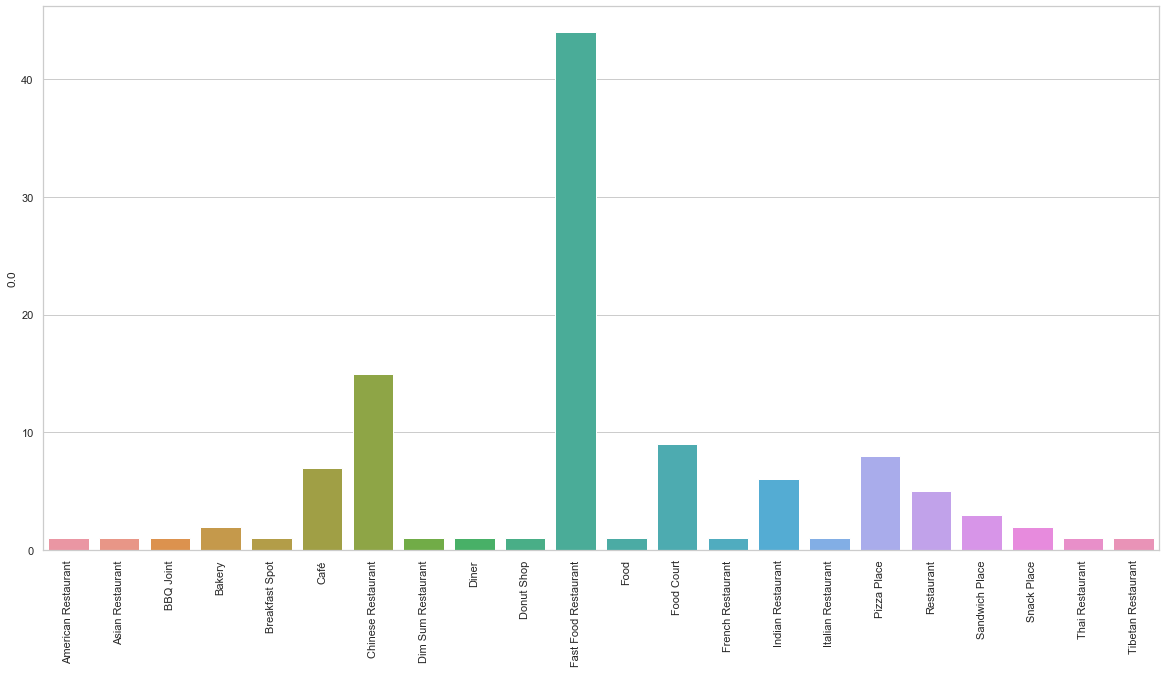

In [89]:
plot_bar(0)

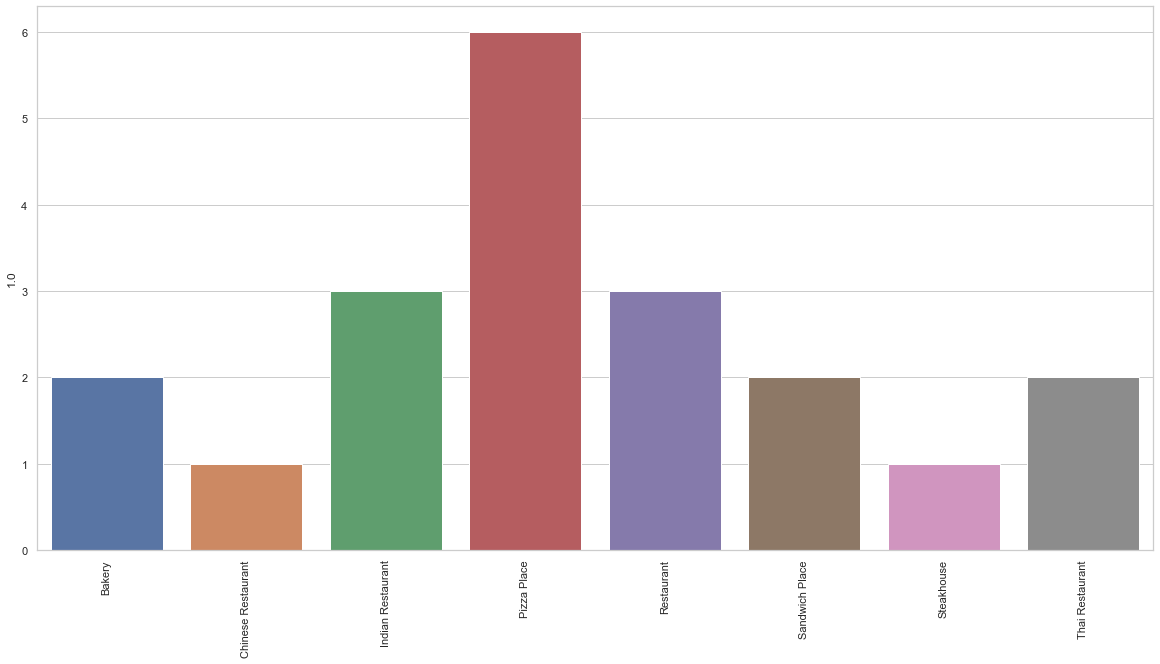

In [90]:
plot_bar(1)

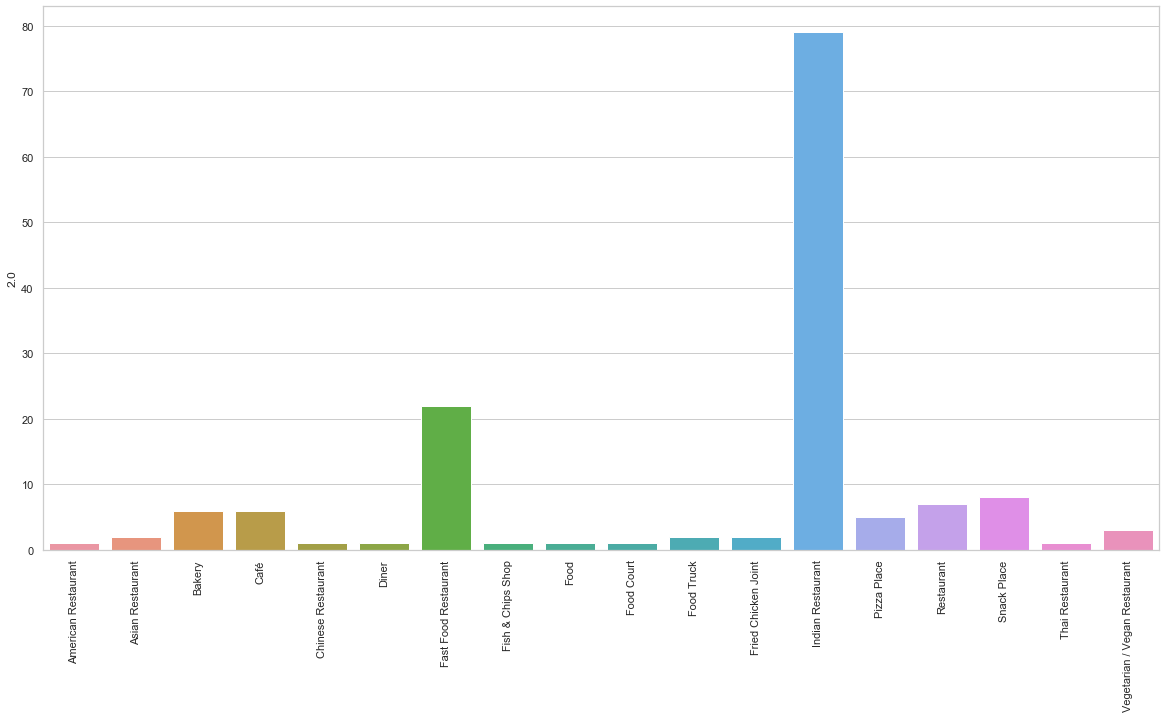

In [91]:
plot_bar(2)

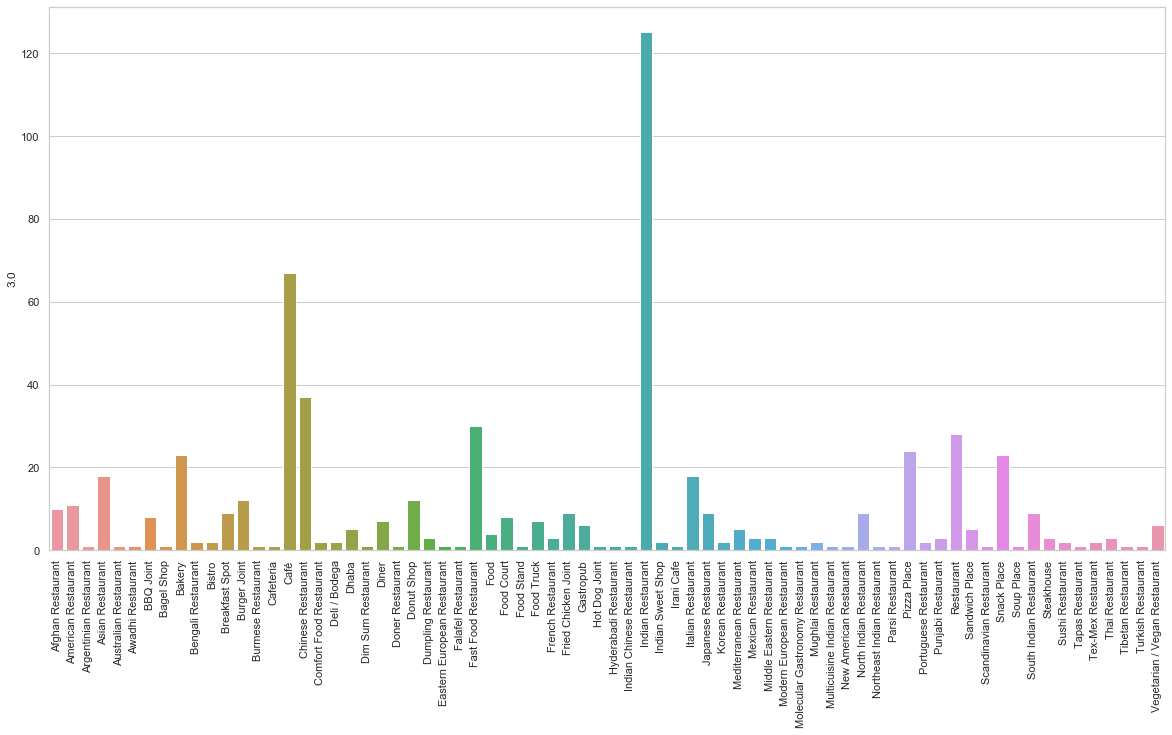

In [92]:
plot_bar(3)

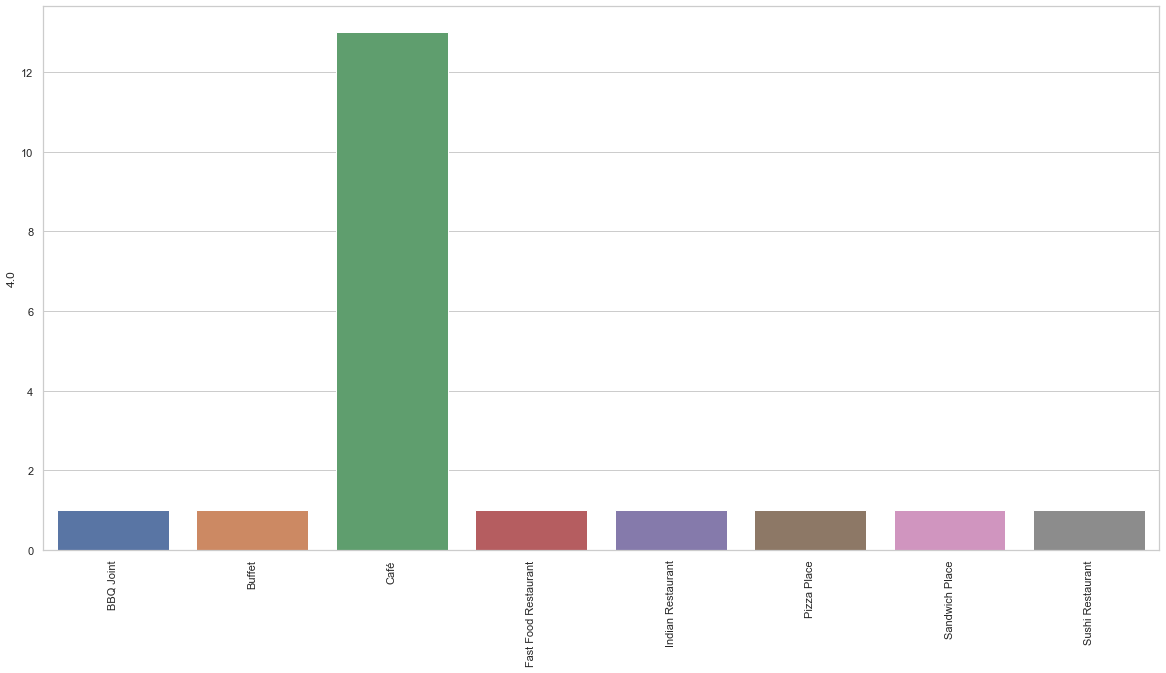

In [93]:
plot_bar(4)

Analysing the bar graphs we can clearly see that clusters 1 and 2 have a high demand for Indian Restaurants

### Recommendation

##### In this section:
we will, first, analyze the density of the Indian Restaurants in generally for each neighborhood.
Then we will weed out the neighborhoods that in the highest 70 percentile of density
Find out the most popular neighborhoods
Will then try to find remaining neighborhoods that are close to them
Provide the a detailed recommendation of top 10 neighborhoods

Now, as clusters 1 and 2 have a maximum number of Indian Restaurants, we will focus our search on neighborhoods within these two clusters.

#### Why?
We know that when we were clustering the neighborhoods the data used contained the mean of all types of restaurants present in the particular neighborhood. Therefore, we can say that the neighborhoods are clustered on their restaurant trends.

Now, clusters 2 and 3 may collectively have the highest number of indian restaurant but there will be some neighborhoods in these clusters which would have a demand for Indian Restaurants, as these neighborhoods are in the same cluster, but would not have enough supply.

In [96]:
forheatmap=delhi_venues.copy()
forheatmap=pd.merge(forheatmap,delhi_merged[['Neighborhood','Cluster Labels']],left_on='Neighborhood', right_on='Neighborhood',how='inner')
forheatmap.drop(forheatmap[~forheatmap['Cluster Labels'].isin([1,2])].index, inplace=True)

In [97]:
forheatmap.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster Labels
4,Ashok Vihar,28.699453,77.184826,Nat Khat Caterers,28.699630,77.187832,Indian Restaurant,2.0
5,Ashok Vihar,28.699453,77.184826,Bakers Stop,28.700495,77.188716,Bakery,2.0
6,Ashok Vihar,28.699453,77.184826,Invitation Banquet,28.696018,77.185953,Diner,2.0
7,Ashok Vihar,28.699453,77.184826,Gola Northend,28.701242,77.189288,Indian Restaurant,2.0
17,Kohat Enclave,28.698041,77.140539,Peshawari,28.699012,77.139020,Indian Restaurant,2.0


In [98]:
from folium.plugins import HeatMap

In [99]:
#heat map of all restaurants in selected Neighborhoods
res_heat = folium.Map(location=[latitude, longitude], zoom_start=11)
HeatMap(list(zip(forheatmap['Venue Latitude'],forheatmap['Venue Longitude'])),
        min_opacity=0.2,
        radius=10, blur=15,
        max_zoom=1
       ).add_to(res_heat)
for lat, lng, label in zip(forheatmap['Neighborhood Latitude'], forheatmap['Neighborhood Longitude'], forheatmap['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(res_heat)
res_heat

In [100]:
forindres = forheatmap[forheatmap['Venue Category']=='Indian Restaurant']

# heat map for Indian Restaurants in the selected Neighborhoods
res_heat_ind = folium.Map(location=[latitude, longitude], zoom_start=11)
HeatMap(list(zip(forindres['Venue Latitude'],forindres['Venue Longitude'])),
        min_opacity=0.2,
        radius=10, blur=15,
        max_zoom=1
       ).add_to(res_heat_ind)
for lat, lng, label in zip(forindres['Neighborhood Latitude'], forindres['Neighborhood Longitude'], forindres['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(res_heat_ind)
res_heat_ind

now we will remove all neighborhoods with the following conditions:

Number of Indian restaurants >30%

Number of all restaurants >60%

'%' here refers to percentile

In [101]:
count_all = forheatmap[['Neighborhood','Venue']].groupby('Neighborhood').count().sort_values(by='Venue')
target_count = int(0.6*len(count_all))
print(count_all.iloc[target_count])
count_all.drop(count_all[count_all.Venue.values>7].index,inplace=True)
count_all.columns=['all count']
count_all.head()

Venue    4
Name: Jasola, dtype: int64


,all count
Neighborhood,
Vivek Vihar,1
Roshanara Bagh,1
Rithala,1
Pratap Nagar,1
Pragati Maidan,1


In [102]:
count_ind = forheatmap[forheatmap['Venue Category']=="Indian Restaurant"][['Neighborhood','Venue']].groupby('Neighborhood').count().sort_values(by='Venue')
target_count = int(0.3*len(count_ind))
print(count_ind.iloc[target_count])
count_ind.drop(count_ind[count_ind.Venue.values>1].index,inplace=True)
count_ind.columns = ['ind count']
count_ind.head()

Venue    2
Name: Pandav Nagar, dtype: int64


,ind count
Neighborhood,
Vivek Vihar,1
Bali Nagar,1
Roshanara Bagh,1
Pragati Maidan,1
Ghitorni,1


In [103]:
lowdensity = count_all.join(count_ind)
lowdensity.index.values

array(['Vivek Vihar', 'Roshanara Bagh', 'Rithala', 'Pratap Nagar',
       'Pragati Maidan', 'Geeta Colony', 'Inderpuri',
       'New Friends Colony', 'Ghitorni', 'Khanpur', 'Pandav Nagar',
       'Jhilmil Colony', 'Naraina', 'Pitam Pura', 'Rangpuri', 'Mehrauli',
       'Meera Bagh', 'Ashok Vihar', 'Vikaspuri', 'Jhandewalan', 'Jasola',
       'Gulmohar Park', 'Daryaganj', 'Bali Nagar', 'Lahori Gate',
       'Munirka', 'Patparganj', 'Dilshad Garden', 'Chawri Bazaar',
       'Mahipalpur'], dtype=object)

In [104]:
temp_recommend = delhiData.copy()
temp_recommend.drop(temp_recommend[~temp_recommend['Neighborhood'].isin(lowdensity.index.values)].index, inplace=True)
temp_recommend.head()

,Borough,Neighborhood,latitude,longitude
1,North West Delhi,Ashok Vihar,28.699453,77.184826
12,North West Delhi,Pitam Pura,28.703268,77.132250
14,North West Delhi,Rithala,28.720806,77.107181
19,North Delhi,Chawri Bazaar,28.649927,77.229788
25,North Delhi,Lahori Gate,28.656841,77.218534


Now, we will add the last constraint i.e the neighborhood should be close to popular neighborhoods

In [105]:
#most popular neighborhoods
top_nei = delhi_venues[['Neighborhood','Venue']].groupby('Neighborhood').count().sort_values(by='Venue', ascending=False).head(3).index.values
top_nei

array(['Connaught Place', 'Khirki Village', 'Hauz Khas Village'],
      dtype=object)

In [106]:
toplatlng = delhiData[['Neighborhood','latitude','longitude']][delhiData['Neighborhood'].isin(top_nei)].reset_index()
toplatlng

,index,Neighborhood,latitude,longitude
0,58,Connaught Place,28.631383,77.219792
1,95,Hauz Khas Village,28.553855,77.194713
2,103,Khirki Village,28.529885,77.218077


In [107]:
from math import sin, cos, sqrt, atan2, radians

def distanceInKM(la1,lo1,la2,lo2):
    # approximate radius of earth in km
    R = 6373.0
    
    lat1 = radians(la1)
    lon1 = radians(lo1)
    lat2 = radians(la2)
    lon2 = radians(lo2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    dis = R * c
    return round(dis,4)

print("Result:", distanceInKM(toplatlng.iloc[2]['latitude'],toplatlng.iloc[2]['longitude'],toplatlng.iloc[0]['latitude'],toplatlng.iloc[0]['longitude']))

Result: 11.2908


In [108]:
temp_recommend.reset_index(inplace=True)

In [109]:
temp_recommend.drop(columns=['index','Borough'], inplace=True)

In [110]:
temp_recommend.head()

,Neighborhood,latitude,longitude
0,Ashok Vihar,28.699453,77.184826
1,Pitam Pura,28.703268,77.132250
2,Rithala,28.720806,77.107181
3,Chawri Bazaar,28.649927,77.229788
4,Lahori Gate,28.656841,77.218534


In [111]:
for i in toplatlng.index:
    temp_recommend[toplatlng.iloc[i]['Neighborhood']] = temp_recommend.apply(lambda x : distanceInKM(toplatlng.iloc[i]['latitude'],toplatlng.iloc[i]['longitude'],x['latitude'],x['longitude']),axis=1)

In [112]:
temp_recommend.head()

,Neighborhood,latitude,longitude,Connaught Place,Hauz Khas Village,Khirki Village
0,Ashok Vihar,28.699453,77.184826,8.3050,16.2236,19.1385
1,Pitam Pura,28.703268,77.132250,11.7016,17.7027,21.0274
2,Rithala,28.720806,77.107181,14.8223,20.4417,23.8370
3,Chawri Bazaar,28.649927,77.229788,2.2818,11.2216,13.4011
4,Lahori Gate,28.656841,77.218534,2.8344,11.6889,14.1214


In [113]:
# top 5 neighborhoods near Connaught Place
neiNearCP = temp_recommend.sort_values(by=['Connaught Place']).iloc[:,:3].head().set_index('Neighborhood')
neiNearCP

,latitude,longitude
Neighborhood,,
Chawri Bazaar,28.649927,77.229788
Pragati Maidan,28.623459,77.242512
Jhandewalan,28.644336,77.199927
Daryaganj,28.646090,77.243048
Lahori Gate,28.656841,77.218534


In [114]:
# top 5 neighborhoods near Hauz Khas Village
neiNearHK = temp_recommend.sort_values(by=['Hauz Khas Village']).iloc[:,:3].head().set_index('Neighborhood')
neiNearHK

,latitude,longitude
Neighborhood,,
Gulmohar Park,28.557101,77.213006
Munirka,28.554886,77.171084
Mehrauli,28.521826,77.178323
Khanpur,28.512798,77.232395
Mahipalpur,28.544485,77.125691


In [115]:
# top 5 neighborhoods near Khirki Village
neiNearKV = temp_recommend.sort_values(by=['Khirki Village']).iloc[:,:3].head().set_index('Neighborhood')
neiNearKV

,latitude,longitude
Neighborhood,,
Khanpur,28.512798,77.232395
Gulmohar Park,28.557101,77.213006
Mehrauli,28.521826,77.178323
Munirka,28.554886,77.171084
New Friends Colony,28.567101,77.269764


In [116]:
final_recommend=neiNearCP.append(neiNearHK).append(neiNearKV).reset_index()
final_recommend.drop_duplicates(inplace=True)
final_recommend.reset_index(inplace=True)
final_recommend.drop(columns=['index'],inplace=True)
final_recommend

,Neighborhood,latitude,longitude
0,Chawri Bazaar,28.649927,77.229788
1,Pragati Maidan,28.623459,77.242512
2,Jhandewalan,28.644336,77.199927
3,Daryaganj,28.646090,77.243048
4,Lahori Gate,28.656841,77.218534
5,Gulmohar Park,28.557101,77.213006
6,Munirka,28.554886,77.171084
7,Mehrauli,28.521826,77.178323
8,Khanpur,28.512798,77.232395
9,Mahipalpur,28.544485,77.125691


## Final Recommendation

In [118]:
final = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(final_recommend['latitude'], final_recommend['longitude'], final_recommend['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(final)  
    
final

# Results and Discussions

Our Analysis was done on over 113 neighborhoods, containing over 848 restaurants within 2km radius of every neighborhood. We segragated these neighborhoods on the basis of types and amounts of restaurants. Five clusters were obtained, each having a unique collection of restaurants. Since, we were focused on finding optimal neighborhoods for opening Indian restaurants, we selected cluster 2 and 3 which had the highest number of Indian restaurants. The above actions left us with the only those neighborhoods that had a shared characteristics of and that had a high demand for Indian restaurants.

Next, we plotted a heat map for analysing the density of restaurants in the remaining neighborhoods. This allowed us to select neighborhoods that had few or no Indian restaurants and were not overcrowded by other kinds of restaurants. A total of 57 neighborhoods were left. After this, we found out the top three most popular neighborhoods(namely: Canaught Place, Hauz khas Village and Khirki Village), and the distance of every remaining neighborhoods from all three of them. Then, we extracted top 5 closest neighborhoods from each of three most popular neighborhoods mentioned above. Taking the union of the resulting three dataset we get 11 neighborhoods that satisfy all three conditons layed out in the business problem by the customer.

The neighborhoods recommendation obtained here are not completely accurate. This is due to the limitations in the dataset used in the project. Due to lack of cross referencing sources, we may have missed a few neighborhoods from our consideration. The foursquare API does not contain, or does not rely, a comprehensive dataset about the restaurants present in delhi. Surely, in a city like Delhi with a population of over 19 million, there are much more restaurants than 848.